In [1]:
import os

os.environ['POLARS_MAX_THREADS'] = '16'

import polars as pl
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
import osmnx as ox
import glob
import pandas as pd
import tqdm
import concurrent.futures 
from scipy.spatial.distance import cdist
from functools import lru_cache

np.random.seed(1234)

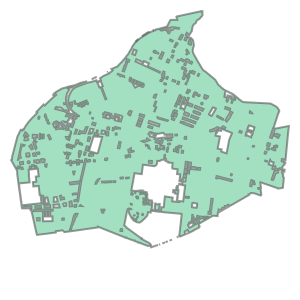

In [2]:
gdf_kom = gpd.read_parquet('data/dk_kom_geo.pq')
kom_geom = gdf_kom[gdf_kom['nationalcode']==147].reset_index(drop=True)['geometry'][0]
kom_geom

In [3]:
kom = 147

df = (pl.scan_parquet('data/dk_adresser.pq', low_memory = True)
        .filter(pl.col("kommunekode")==kom)
        .select(pl.col("vejnavn", "husnr", "postnr", "kommunekode", "landsdelsnuts3"), pl.col("etrs89koordinat_øst").alias("etrs89_east"), pl.col("etrs89koordinat_nord").alias("etrs89_north"))
        .filter(pl.struct(pl.col("etrs89_east", "etrs89_north")).is_first_distinct())
        .collect(engine = 'streaming')
        .to_pandas()
)

gdf_adr = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x = df.etrs89_east, y=df.etrs89_north), crs=25832)

kom_shape = gdf_kom[gdf_kom['nationalcode']==kom].reset_index(drop=True)


In [4]:
gdf_adr.voronoi_polygons(extend_to=kom_geom)

0       POLYGON ((715410.51 6176760.152, 718386.46 617...
1       POLYGON ((715410.51 6176196.792, 719436.312 61...
2       POLYGON ((719533.286 6175890.689, 719436.312 6...
3       POLYGON ((715410.51 6175641.359, 719532.499 61...
4       POLYGON ((719533.44 6175873.974, 719532.499 61...
                              ...                        
9564    POLYGON ((723735.232 6176084.336, 723692.724 6...
9565    POLYGON ((723567.289 6176201.692, 723567.307 6...
9566    POLYGON ((723567.307 6176202.346, 723564.354 6...
9567    POLYGON ((723573.055 6176217.86, 723573.336 61...
9568    POLYGON ((723832.828 6176248.936, 723592.935 6...
Length: 9569, dtype: geometry

<Axes: >

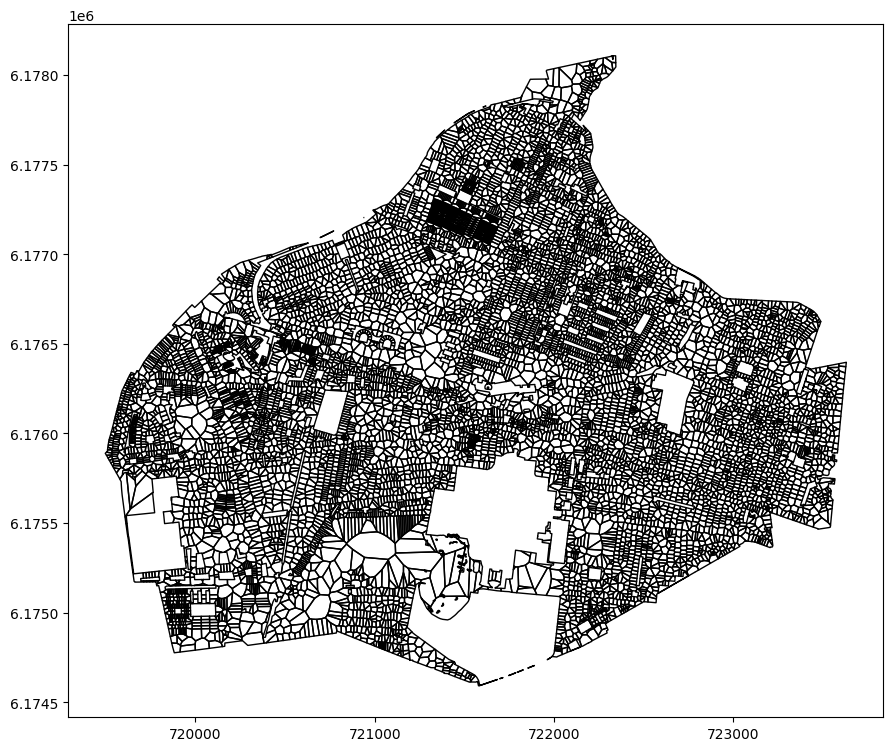

In [29]:
kom = 147

fig,ax = plt.subplots(figsize = (15, 9))

df = (pl.scan_parquet('data/dk_adresser.pq', low_memory = True)
        .filter(pl.col("kommunekode")==kom)
        .select(pl.col("vejnavn", "husnr", "postnr", "kommunekode", "landsdelsnuts3"), pl.col("etrs89koordinat_øst").alias("etrs89_east"), pl.col("etrs89koordinat_nord").alias("etrs89_north"))
        .filter(pl.struct(pl.col("etrs89_east", "etrs89_north")).is_first_distinct())
        .collect(engine = 'streaming')
        .to_pandas()
)

gdf_adr = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x = df.etrs89_east, y=df.etrs89_north), crs=25832)

kom_shape = gdf_kom[gdf_kom['nationalcode']==kom].reset_index(drop=True)
voronoi_polys = gpd.GeoDataFrame(geometry=gdf_adr.voronoi_polygons(extend_to=kom_geom))

gdf_adr = gdf_adr.sjoin(voronoi_polys, how = 'right', predicate='within').drop('index_left', axis=1)
gdf_adr['voronoi'] = gdf_adr['geometry']
gdf_adr['point'] = gpd.points_from_xy(x = gdf_adr.etrs89_east, y=gdf_adr.etrs89_north, crs = 25832)



gdf_adr = gdf_adr.drop('geometry', axis=1)
gdf_adr = gdf_adr.set_geometry('voronoi')
gdf_adr = gpd.overlay(kom_shape, gdf_adr)
gdf_adr.plot(ax = ax, facecolor='none', edgecolor='k')

In [30]:

import random
from shapely.geometry import Point

n_districts = 8

# Randomly select seed polygons as schools
school_seeds = gdf_adr.sample(n=n_districts, random_state=1234).copy().reset_index(drop=True)
school_seeds['school_district'] = range(n_districts)
school_seeds

nationalcode                 vejnavn husnr  postnr  kommunekode  \
0           147             Glahns Alle    23    2000          147   
1           147             Godthåbsvej   150    2000          147   
2           147               Vagtelvej    32    2000          147   
3           147  Christian Winthers Vej    13    1860          147   
4           147                 Fuglebo    17    2000          147   
5           147             Hostrupsvej    20    1950          147   
6           147             Nyelandsvej    67    2000          147   
7           147   Gustav Johannsens Vej    58    2000          147   

  landsdelsnuts3  etrs89_east  etrs89_north                         point  \
0          DK011    720359.47    6175631.64  POINT (720359.47 6175631.64)   
1          DK011    721119.22    6177256.14  POINT (721119.22 6177256.14)   
2          DK011    721338.69    6177260.48  POINT (721338.69 6177260.48)   
3          DK011    722319.70    6176245.66   POINT (722319.7 6176245.66)   
4          DK011    721765.71    6177501.77  POINT (721765.71 6177501.77)   
5          DK011    722440.90    6176337.69   POINT (722440.9 6176337.69)   
6          DK011    721499.32    6176575.79  POINT (721499.32 6176575.79)   
7          DK011    720066.21    6176265.00     POINT (720066.21 6176265)   

                                            geometry  school_district  
0  POLYGON ((720321.869 6175638.922, 720380.956 6...                0  
1  POLYGON ((721113.749 6177267.393, 721135.48 61...                1  
2  POLYGON ((721317.987 6177271.476, 721364.128 6...                2  
3  POLYGON ((722307.879 6176277.332, 722322.511 6...                3  
4  POLYGON ((721755.8 6177490.147, 721767.313 617...                4  
5  POLYGON ((722459.087 6176332.212, 722457.696 6...                5  
6  POLYGON ((721480.968 6176568.977, 721489.667 6...                6  
7  POLYGON ((720059.96 6176262.196, 720058.749 61...                7

In [31]:
def assign_school(gdf_adr: gpd.GeoDataFrame, gdf_school: gpd.GeoDataFrame, prob: bool = True) -> gpd.GeoSeries:
    p1 = gdf_adr[['etrs89_east', 'etrs89_north']].to_numpy()

    p2 = gdf_school[['etrs89_east', 'etrs89_north']].to_numpy()

    distances = cdist(p1, p2)

    # Get indices of the 3 nearest schools for each address
    nearest_schools = np.argsort(distances, axis=1)[:, :3]
    

    if prob is True:
        # Probabilities for 1st, 2nd, 3rd nearest
        probs = [0.85, 0.1, 0.05]

        # Randomly assign based on probabilities
        assignments = [
            np.random.choice(nearest_schools[i], p=probs)
            for i in range(len(nearest_schools))
        ]

        school_assignment = np.array(assignments)
    
    else:
        school_assignment = np.argmin(distances, axis=1)

    return school_assignment

In [32]:
p1 = gdf_adr[['etrs89_east', 'etrs89_north']].to_numpy()

p2 = school_seeds[['etrs89_east', 'etrs89_north']].to_numpy()

distances = cdist(p1, p2)

# Get indices of the 3 nearest schools for each address
nearest_schools = np.argsort(distances, axis=1)[:, :3]

nearest_schools

array([[7, 0, 1],
       [7, 0, 6],
       [7, 0, 6],
       ...,
       [5, 3, 6],
       [5, 3, 6],
       [5, 3, 6]], shape=(9557, 3))

In [33]:
np.argmin(distances, axis = 1)

array([7, 7, 7, ..., 5, 5, 5], shape=(9557,))

In [34]:
school_seeds.loc[7]

nationalcode                                                     147
vejnavn                                        Gustav Johannsens Vej
husnr                                                             58
postnr                                                          2000
kommunekode                                                      147
landsdelsnuts3                                                 DK011
etrs89_east                                                720066.21
etrs89_north                                               6176265.0
point                                      POINT (720066.21 6176265)
geometry           POLYGON ((720059.9596528029 6176262.196021788,...
school_district                                                    7
Name: 7, dtype: object

In [35]:
gdf_adr.loc[0]

nationalcode                                                    147
vejnavn                                         Hf. Zenia-Lindevang
husnr                                                            15
postnr                                                         2000
kommunekode                                                     147
landsdelsnuts3                                                DK011
etrs89_east                                               719515.33
etrs89_north                                              6175915.3
point                                   POINT (719515.33 6175915.3)
geometry          POLYGON ((719509.76 6175908.84, 719510.1700000...
Name: 0, dtype: object

<Axes: >

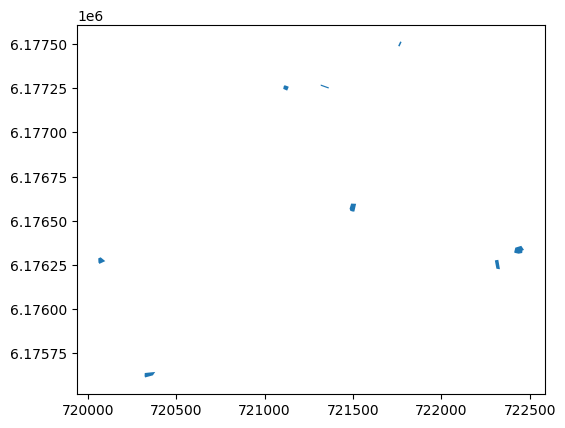

In [36]:
school_seeds.plot()

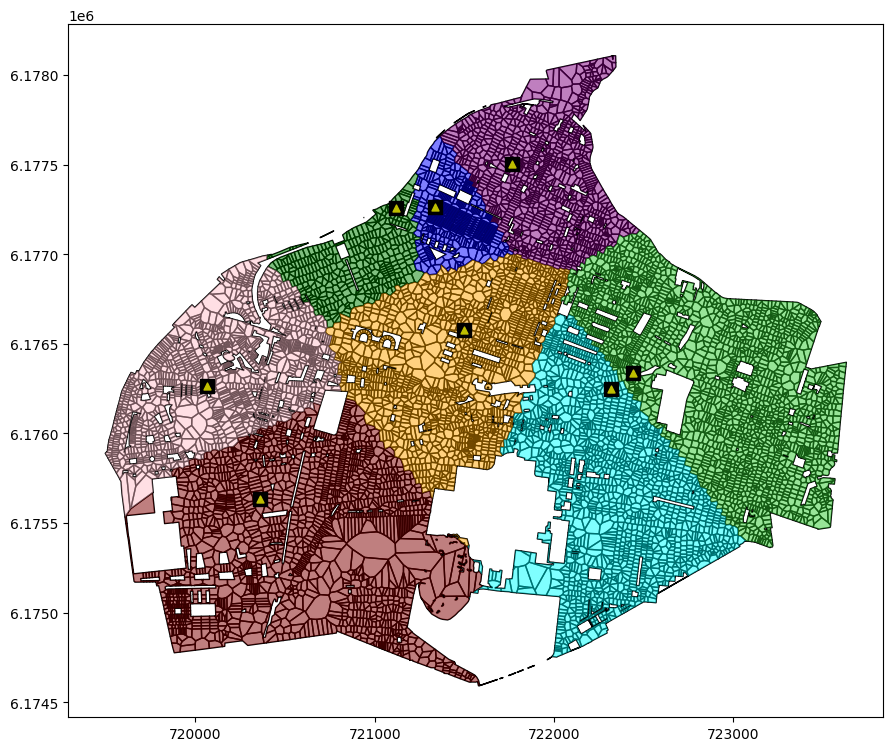

In [49]:
gdf_adr['school_district'] = assign_school(gdf_adr=gdf_adr, gdf_school=school_seeds, prob = False)

fig,ax = plt.subplots(figsize = (15, 9))

gdf_adr.plot(ax=ax, facecolor='none', edgecolor='k')




gdf_adr[gdf_adr['school_district']==0].plot(ax=ax, facecolor='maroon', alpha=0.5)
gdf_adr[gdf_adr['school_district']==1].plot(ax=ax, facecolor='green', alpha=0.5)
gdf_adr[gdf_adr['school_district']==2].plot(ax=ax, facecolor='blue', alpha=0.5)
gdf_adr[gdf_adr['school_district']==3].plot(ax=ax, facecolor='cyan', alpha=0.5)
gdf_adr[gdf_adr['school_district']==4].plot(ax=ax, facecolor='purple', alpha=0.5)
gdf_adr[gdf_adr['school_district']==5].plot(ax=ax, facecolor='limegreen', alpha=0.5)
gdf_adr[gdf_adr['school_district']==6].plot(ax=ax, facecolor='orange', alpha=0.5)
gdf_adr[gdf_adr['school_district']==7].plot(ax=ax, facecolor='pink', alpha=0.5)

school_seeds['point'].plot(ax = ax, color= 'k', markersize = 100, marker = 's')
school_seeds['point'].plot(ax = ax, color= 'y', markersize = 25, marker = '^')

fig.savefig('figs/voronoi_tess_fberg_school.pdf', bbox_inches = 'tight')
fig.savefig('figs/voronoi_tess_fber_school.png', bbox_inches = 'tight')

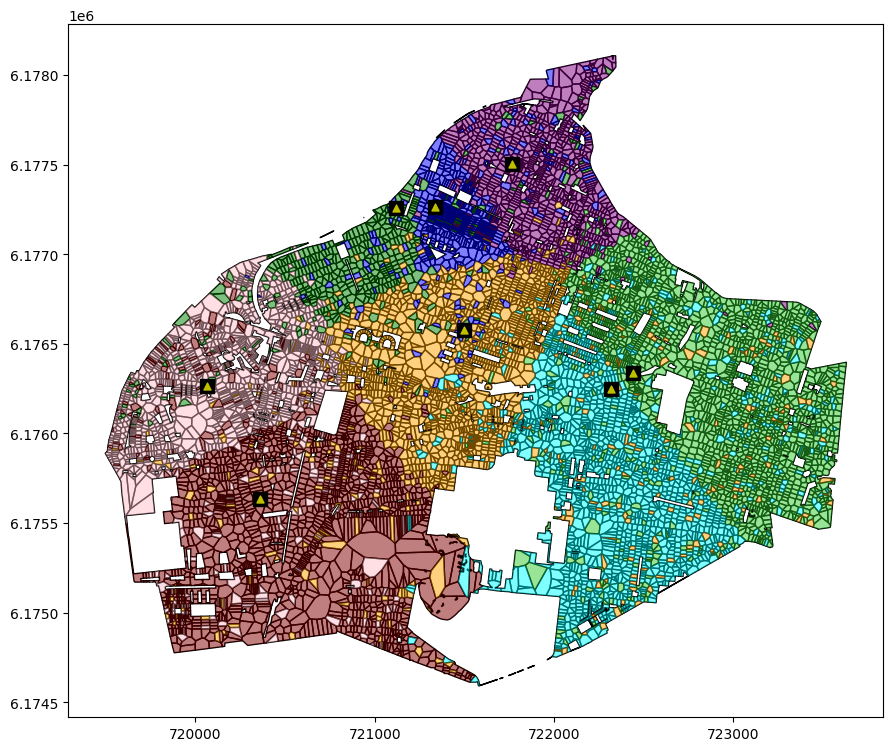

In [50]:
gdf_adr['school_district'] = assign_school(gdf_adr=gdf_adr, gdf_school=school_seeds, prob = True)

fig,ax = plt.subplots(figsize = (15, 9))

gdf_adr.plot(ax=ax, facecolor='none', edgecolor='k')




gdf_adr[gdf_adr['school_district']==0].plot(ax=ax, facecolor='maroon', alpha=0.5)
gdf_adr[gdf_adr['school_district']==1].plot(ax=ax, facecolor='green', alpha=0.5)
gdf_adr[gdf_adr['school_district']==2].plot(ax=ax, facecolor='blue', alpha=0.5)
gdf_adr[gdf_adr['school_district']==3].plot(ax=ax, facecolor='cyan', alpha=0.5)
gdf_adr[gdf_adr['school_district']==4].plot(ax=ax, facecolor='purple', alpha=0.5)
gdf_adr[gdf_adr['school_district']==5].plot(ax=ax, facecolor='limegreen', alpha=0.5)
gdf_adr[gdf_adr['school_district']==6].plot(ax=ax, facecolor='orange', alpha=0.5)
gdf_adr[gdf_adr['school_district']==7].plot(ax=ax, facecolor='pink', alpha=0.5)

school_seeds['point'].plot(ax = ax, color= 'k', markersize = 100, marker = 's')
school_seeds['point'].plot(ax = ax, color= 'y', markersize = 25, marker = '^')

fig.savefig('figs/voronoi_tess_fberg_school_w_prob.pdf', bbox_inches = 'tight')
fig.savefig('figs/voronoi_tess_fber_school_w_prob.png', bbox_inches = 'tight')

In [150]:
def assign_school(g_series: gpd.GeoSeries):
    distances = school_seeds['point'].apply(lambda s: g_series.distance(s))
    return school_seeds.loc[distances.idxmin(), 'school_id']
gdf_adr['school_district'] = gdf_adr['point'].apply(assign_school)
gdf_adr

nationalcode              vejnavn husnr  postnr  kommunekode  \
0              147  Hf. Zenia-Lindevang    15    2000          147   
1              147  Hf. Zenia-Lindevang    11    2000          147   
2              147  Hf. Zenia-Lindevang    13    2000          147   
3              147  Hf. Zenia-Lindevang     9    2000          147   
4              147  Hf. Zenia-Lindevang    12    2000          147   
...            ...                  ...   ...     ...          ...   
9552           147            Suomisvej     7    1927          147   
9553           147           Martinsvej    10    1926          147   
9554           147           Martinsvej     9    1926          147   
9555           147           Martinsvej     7    1926          147   
9556           147          Vodroffsvej   56B    1900          147   

     landsdelsnuts3  etrs89_east  etrs89_north  \
0             DK011    719515.33    6175915.30   
1             DK011    719513.23    6175886.19   
2             DK011    719515.67    6175901.28   
3             DK011    719514.12    6175870.79   
4             DK011    719552.74    6175877.28   
...             ...          ...           ...   
9552          DK011    723579.83    6176142.29   
9553          DK011    723581.21    6176188.88   
9554          DK011    723584.44    6176211.35   
9555          DK011    723582.46    6176227.00   
9556          DK011    723600.97    6176327.16   

                               point  \
0       POINT (721167.76 6176714.85)   
1       POINT (719905.99 6176389.14)   
2          POINT (721810.13 6177364)   
3       POINT (719838.09 6176381.92)   
4       POINT (719863.01 6176392.29)   
...                              ...   
9552  POINT (720739.271 6175554.545)   
9553  POINT (721845.047 6177844.383)   
9554  POINT (720317.401 6176428.333)   
9555  POINT (720689.381 6175345.956)   
9556   POINT (720737.814 6175545.66)   

                                               geometry  school_district  
0     POLYGON ((719509.76 6175908.84, 719510.17 6175...               11  
1     POLYGON ((719497.14 6175889.26, 719503.95 6175...                6  
2     POLYGON ((719509.12 6175900.12, 719509.177 617...                9  
3     POLYGON ((719506.44 6175873.45, 719503.811 617...                6  
4     POLYGON ((719532.499 6175879.578, 719533.731 6...                6  
...                                                 ...              ...  
9552  POLYGON ((723607 6176163.58, 723606.96 6176163...                2  
9553  POLYGON ((723609.82 6176195.57, 723609.8 61761...                9  
9554  POLYGON ((723609.879 6176196.226, 723567.307 6...                6  
9555  POLYGON ((723614.5 6176243.52, 723612.97 61762...                7  
9556  POLYGON ((723623.5 6176329.84, 723621.65 61763...                2  

[9557 rows x 11 columns]

In [144]:
gdf_adr[gdf_adr['vejnavn']=="Smallegade"]['point'].apply(lambda s: s.distance(school_seeds['point']))

8503         7752         9350         8414         7671  \
3856   825.188138  1474.707161   979.282567  1615.627867  2891.392507   
3943  1719.536800  1965.947838  2251.939257   482.441762  1777.889699   
3944  1801.039627  2008.125877  2326.988184   606.158868  1703.361769   
3955  2347.644508  2413.096124  2842.785457  1262.848111  1566.671848   
4009  2585.708476  2426.559480  2994.036765  1845.677573  1033.562607   
...           ...          ...          ...          ...          ...   
5835   642.951655    71.196436   690.946150  1648.760883  1679.828281   
5847   536.684919   160.316535   542.587674  1658.292303  1824.524265   
5927  1947.754187  1725.160654  2315.826940  1513.387571   543.651117   
5945   761.203523   497.478462  1047.457954  1324.171358  1352.808961   
5988  1866.343933  1516.645248  2157.394957  1716.744283   266.238078   

             4738         8677         965          3208         5285  \
3856  2458.453351  2679.214512  2894.642047  2727.092361   711.699160   
3943  1111.664588  1488.026324  1740.745215  1004.551226  1715.289898   
3944  1041.008076  1415.894963  1663.792465   894.720143  1803.537843   
3955  1025.217935  1325.365313  1515.235718   627.438211  2370.582723   
4009   856.912357   916.733852   978.854960   507.090234  2643.920209   
...           ...          ...          ...          ...          ...   
5835  1521.353722  1563.318950  1702.499831  1941.693746   763.856389   
5847  1639.882446  1699.940066  1845.980713  2050.339076   655.428263   
5927   205.278553   284.033142   498.234934   417.893287  2020.345728   
5945  1100.609723  1190.408538  1365.759177  1510.286818   865.024281   
5988   442.877401   113.146405   257.084616   805.182812  1956.371779   

             4477         9036         8725         518   
3856  2491.304311   568.530319   280.535058   869.063655  
3943  2714.918865  1657.162669  1857.607144  2357.682962  
3944  2715.482815  1756.119859  1975.430650  2440.177530  
3955  2921.859253  2354.494699  2619.250620  2979.542556  
4009  2631.441399  2691.562506  3068.347723  3164.912445  
...           ...          ...          ...          ...  
5835  1100.643940   969.291891  1493.324356   890.412060  
5847  1198.127403   866.721045  1380.337919   741.143760  
5927  1963.452091  2099.539230  2533.245476  2494.688974  
5945  1283.654239  1020.206859  1543.099960  1231.290436  
5988  1603.666731  2071.435709  2550.610277  2348.357853  

[80 rows x 14 columns]

AttributeError: 'Series' object has no attribute 'distance'

<Axes: >

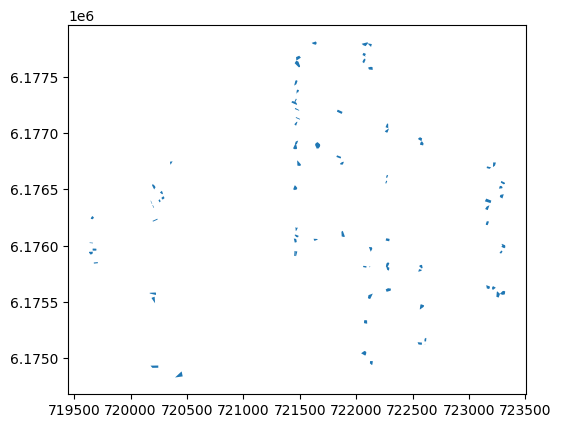

In [38]:
gdf[gdf['vejnavn']=='Smallegade'].plot()

In [ ]:
gdf.voronoi_polygons()

In [29]:
gdf[gdf['school_district']==0]

vejnavn husnr  postnr  kommunekode landsdelsnuts3  \
2284138      Smallegade   30B    2000          147          DK011   
2284139      Smallegade   30C    2000          147          DK011   
2284141      Smallegade   30D    2000          147          DK011   
2284142      Smallegade   41C    2000          147          DK011   
2284143      Smallegade   41D    2000          147          DK011   
...                 ...   ...     ...          ...            ...   
2293515  Ved Andebakken     7    2000          147          DK011   
2293516  Ved Andebakken     9    2000          147          DK011   
2293517  Ved Andebakken     1    2000          147          DK011   
2293518  Ved Andebakken     2    2000          147          DK011   
2293519  Ved Andebakken     6    2000          147          DK011   

         etrs89_east  etrs89_north                        points  \
2284138    721784.47    6176057.66  POINT (721784.47 6176057.66)   
2284139    721781.49    6176066.21  POINT (721781.49 6176066.21)   
2284141    721774.37    6176067.64  POINT (721774.37 6176067.64)   
2284142    721642.09    6175994.86  POINT (721642.09 6175994.86)   
2284143    721628.38    6176002.87  POINT (721628.38 6176002.87)   
...              ...           ...                           ...   
2293515    721811.41    6176056.53  POINT (721811.41 6176056.53)   
2293516    721813.49    6176068.68  POINT (721813.49 6176068.68)   
2293517    721806.43    6176027.75  POINT (721806.43 6176027.75)   
2293518    721828.89    6176023.69  POINT (721828.89 6176023.69)   
2293519    721832.42    6176043.98  POINT (721832.42 6176043.98)   

         nationalcode                                           geometry  \
2284138           147  POLYGON ((719663.868 6175946.999, 719664.981 6...   
2284139           147  POLYGON ((719664.372 6175974.808, 719695.347 6...   
2284141           147  POLYGON ((719708.713 6175854.72, 719709.872 61...   
2284142           147  POLYGON ((719665.745 6176026.685, 719666.431 6...   
2284143           147  POLYGON ((719648.184 6176245.384, 719654.94 61...   
...               ...                                                ...   
2293515           147  POLYGON ((723519.659 6175695.657, 723534.925 6...   
2293516           147  POLYGON ((723526.963 6176097.415, 723531.674 6...   
2293517           147  POLYGON ((723511.839 6175971.661, 723526.672 6...   
2293518           147  POLYGON ((723526.89 6175667.574, 723532.125 61...   
2293519           147  POLYGON ((723529.263 6175923.317, 723554.823 6...   

         school_district  
2284138                0  
2284139                0  
2284141                0  
2284142                0  
2284143                0  
...                  ...  
2293515                0  
2293516                0  
2293517                0  
2293518                0  
2293519                0  

[502 rows x 11 columns]

<Axes: >

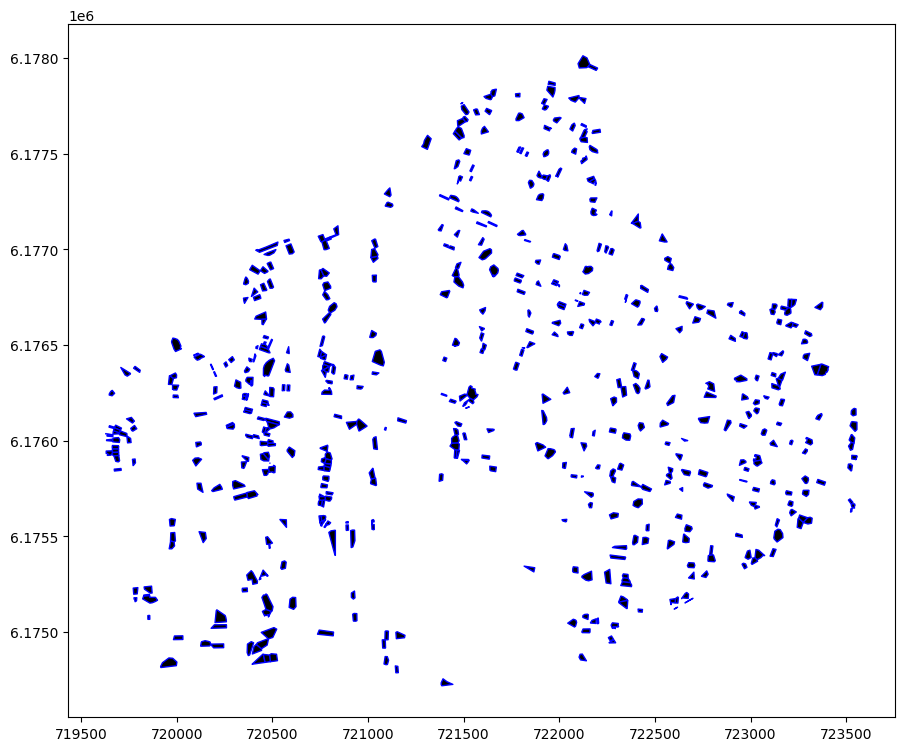

In [31]:
fig,ax = plt.subplots(figsize = (15, 9))

gdf[gdf['school_district']==0].plot(ax = ax, facecolor='black', edgecolor='b')

<Axes: >

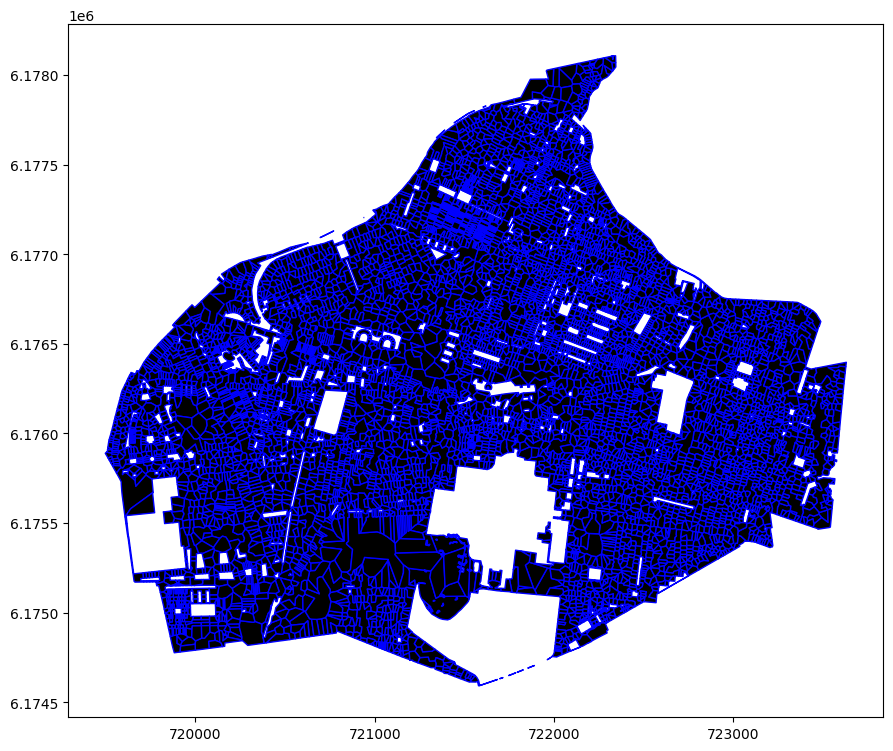

In [25]:
fig,ax = plt.subplots(figsize = (15, 9))

gdf.dissolve(by = 'school_district').plot(ax = ax, facecolor='black', edgecolor='b')

In [ ]:
def clean_kommune(kom: int):
    
    gdf_kom = load_kommune_data().to_crs(4326)

    gdf_kom_filtered = gdf_kom[gdf_kom['nationalcode']==kom]
    
    gdf_water = gpd.read_parquet(f'data/geometry/water_{kom}.pq')
    gdf_park = gpd.read_parquet(f'data/geometry/park_{kom}.pq')
    
    gdf_cleaned = gpd.overlay(gdf_kom_filtered, gdf_water, how='difference')
    gdf_cleaned = gpd.overlay(gdf_cleaned, gdf_park, how='difference')
    gdf_cleaned.to_parquet(f'data/geometry/kom_geom_cleaned_{kom}.pq')
    print(f'Cleaned shapefile for kom={kom}')


In [ ]:
kommunerz = gdf_kom['nationalcode'].to_list()

with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    res = list(tqdm.tqdm(executor.map(clean_kommune, kommunerz)))

files = glob.glob('data/geometry/kom_gemo_cleaned_*.pq')

def concat_geo_data(list: list[str] | str):
    if len(list)==1:
        gdf = gpd.read_parquet(list[0])
        gdf = gdf.reset_index(drop = True)
        gdf.to_parquet('data/dk_adresser_voronoi.pq')
    else:
        gdf = gpd.read_parquet(list[0])
        for data in list:
            if data == list[0]:
                pass
            gdf2 = gpd.read_parquet(data)

            gdf = pd.concat([gdf, gdf2])

            gdf = gdf.reset_index(drop = True)
        gdf.to_parquet('data/dk_adresser_voronoi.pq')

concat_geo_data(files)

In [8]:
# gdf_kom = load_kommune_data().to_crs(4326)

kommunerz = gdf_kom['nationalcode'].to_list()

get_geo_features(kommunerz)

Parsed parks for kom=147
Parsed water for kom=147
Parsed parks for kom=306
Parsed water for kom=306


In [104]:
parks = ox.features_from_polygon(kom_geo, tags={
        'leisure': ['park', 'nature_reserve', 'recreation_ground', 'garden'],
        'landuse': ['recreation_ground', 'forest', 'meadow']
    }).polygonize()

parks = gpd.GeoDataFrame(parks).set_geometry('polygons')

water = ox.features.features_from_polygon(
    kom_geo,
    tags={
        'natural': ['water'],
        'waterway': ['river', 'stream', 'canal'],
        'water': True
    }).polygonize()

water = gpd.GeoDataFrame(water).set_geometry('polygons')

In [107]:
gdf_kom

nationalcode nationallevel inspireid nationallevelname  \
0           147      3rdOrder    389104           Kommune   

       beginlifespanversion endlifespanversion country name_gn_language  \
0 2024-01-16 12:52:12+00:00                NaT      DK              dan   

  name_gn_nativeness name_gn_namestatus name_gn_sourceofname  \
0            endonym           official                 None   

  name_gn_pronunciation name_gn_spell_spellofna_text  \
0                  None                Frederiksberg   

  name_gn_spell_spellofna_script residenceofauthority upperlevelunit boundary  \
0                           Latn                 None         389099     None   

                                            geometry  
0  POLYGON ((12.53735 55.69661, 12.53749 55.69665...

<Axes: >

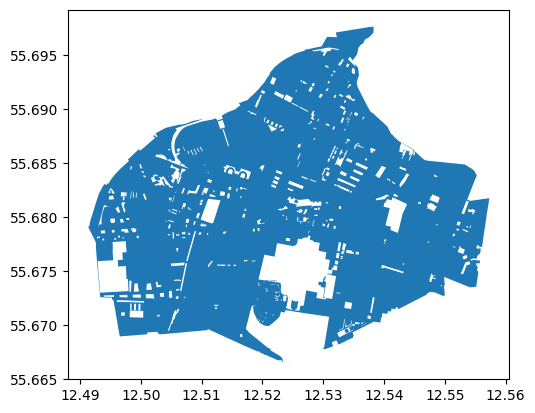

In [106]:
cleaned = gpd.overlay(gdf_kom, water, how='difference')
cleaned = gpd.overlay(cleaned, parks, how='difference')

cleaned.plot()

In [81]:
nodes, edges = ox.graph_to_gdfs(G, fill_edge_geometry=True)

gdf_w_roads = gpd.GeoDataFrame(edges.polygonize()).set_geometry('polygons')

In [83]:
edges

osmid      highway maxspeed  \
u           v           key                                     
375471      298530862   0       8120296     tertiary       50   
375473      277055380   0    1363850164  residential       50   
576730      1043162182  0     162089324     tertiary       50   
            1043162227  0     162089324     tertiary       50   
576731      1036311412  0      87341542     tertiary       50   
...                                 ...          ...      ...   
13031949439 13031949438 0    1418124797      service      NaN   
13031949440 13031949434 0       3663994  residential       40   
            13031949437 0       3663994  residential       40   
            13031949441 0    1418124798      service      NaN   
13031949441 13031949440 0    1418124798      service      NaN   

                                         name  oneway  reversed     length  \
u           v           key                                                  
375471      298530862   0    H.C. Ørsteds Vej   False     False  14.283801   
375473      277055380   0                 NaN   False      True  14.814703   
576730      1043162182  0     Søndre Fasanvej   False     False  10.666133   
            1043162227  0     Søndre Fasanvej   False      True   9.797396   
576731      1036311412  0     Søndre Fasanvej   False     False   2.673077   
...                                       ...     ...       ...        ...   
13031949439 13031949438 0                 NaN   False     False   2.692156   
13031949440 13031949434 0           Normasvej   False     False  73.293586   
            13031949437 0           Normasvej   False      True  36.167243   
            13031949441 0                 NaN   False      True  29.549053   
13031949441 13031949440 0                 NaN   False     False  29.549053   

                            lanes junction bridge width   service access  \
u           v           key                                                
375471      298530862   0     NaN      NaN    NaN   NaN       NaN    NaN   
375473      277055380   0       2      NaN    NaN   NaN       NaN    NaN   
576730      1043162182  0       2      NaN    NaN   NaN       NaN    NaN   
            1043162227  0       2      NaN    NaN   NaN       NaN    NaN   
576731      1036311412  0       2      NaN    NaN   NaN       NaN    NaN   
...                           ...      ...    ...   ...       ...    ...   
13031949439 13031949438 0     NaN      NaN    NaN   NaN  driveway    NaN   
13031949440 13031949434 0     NaN      NaN    NaN   NaN       NaN    NaN   
            13031949437 0     NaN      NaN    NaN   NaN       NaN    NaN   
            13031949441 0     NaN      NaN    NaN   NaN  driveway    NaN   
13031949441 13031949440 0     NaN      NaN    NaN   NaN  driveway    NaN   

                            tunnel  \
u           v           key          
375471      298530862   0      NaN   
375473      277055380   0      NaN   
576730      1043162182  0      NaN   
            1043162227  0      NaN   
576731      1036311412  0      NaN   
...                            ...   
13031949439 13031949438 0      NaN   
13031949440 13031949434 0      NaN   
            13031949437 0      NaN   
            13031949441 0      NaN   
13031949441 13031949440 0      NaN   

                                                                      geometry  
u           v           key                                                     
375471      298530862   0    LINESTRING (12.55181 55.68506, 12.55175 55.68494)  
375473      277055380   0     LINESTRING (12.54728 55.68534, 12.54731 55.6852)  
576730      1043162182  0     LINESTRING (12.51711 55.66961, 12.5171 55.66951)  
            1043162227  0     LINESTRING (12.51711 55.66961, 12.51714 55.6697)  
576731      1036311412  0    LINESTRING (12.51813 55.67186, 12.51812 55.67184)  
...                                                                        ...  
13031949439 13031949438 0     LINESTRING 

In [85]:
gdf_out = gpd.overlay(gdf_kom, edges, how='intersection')
gdf_out

/home/jbh/Desktop/repos/school-boundaries/.venv/lib/python3.12/site-packages/geopandas/tools/overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 16367 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


Empty GeoDataFrame
Columns: [nationalcode, nationallevel, inspireid, nationallevelname, beginlifespanversion, endlifespanversion, country, name_gn_language, name_gn_nativeness, name_gn_namestatus, name_gn_sourceofname, name_gn_pronunciation, name_gn_spell_spellofna_text, name_gn_spell_spellofna_script, residenceofauthority, upperlevelunit, boundary, osmid, highway, maxspeed, name, oneway, reversed, length, lanes, junction, bridge, width, service, access, tunnel, geometry]
Index: []

[0 rows x 32 columns]

In [ ]:
gdf_kom.sjoin(edges).plot()

ValueError: 'right_df' should be GeoDataFrame, got <class 'geopandas.geoseries.GeoSeries'>

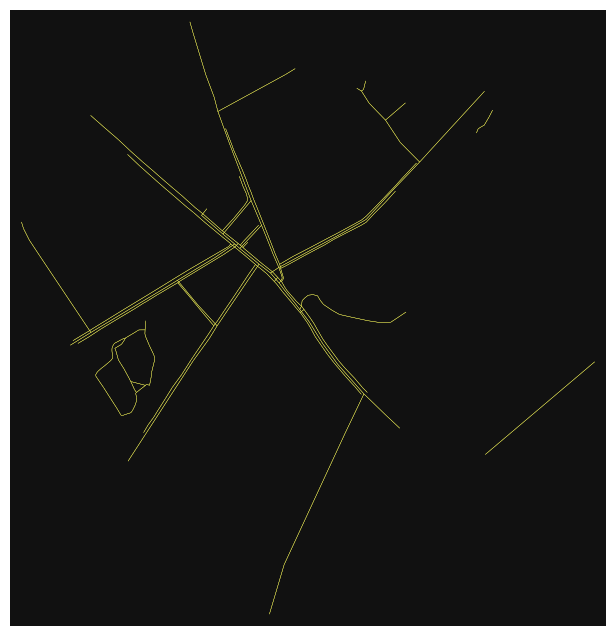

In [18]:
G = ox.graph.graph_from_place('Copenhagen, Denmark', network_type="all", retain_all=True, simplify=False)
fig, ax = ox.plot.plot_graph(G, node_size=0, edge_color="#FFFF5C", edge_linewidth=0.25)

ValueError: aspect must be finite and positive 

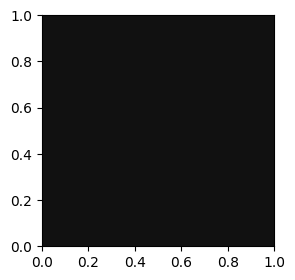

In [11]:


fig, ax = ox.plot.plot_footprints(gdf[0], figsize=(3, 3))



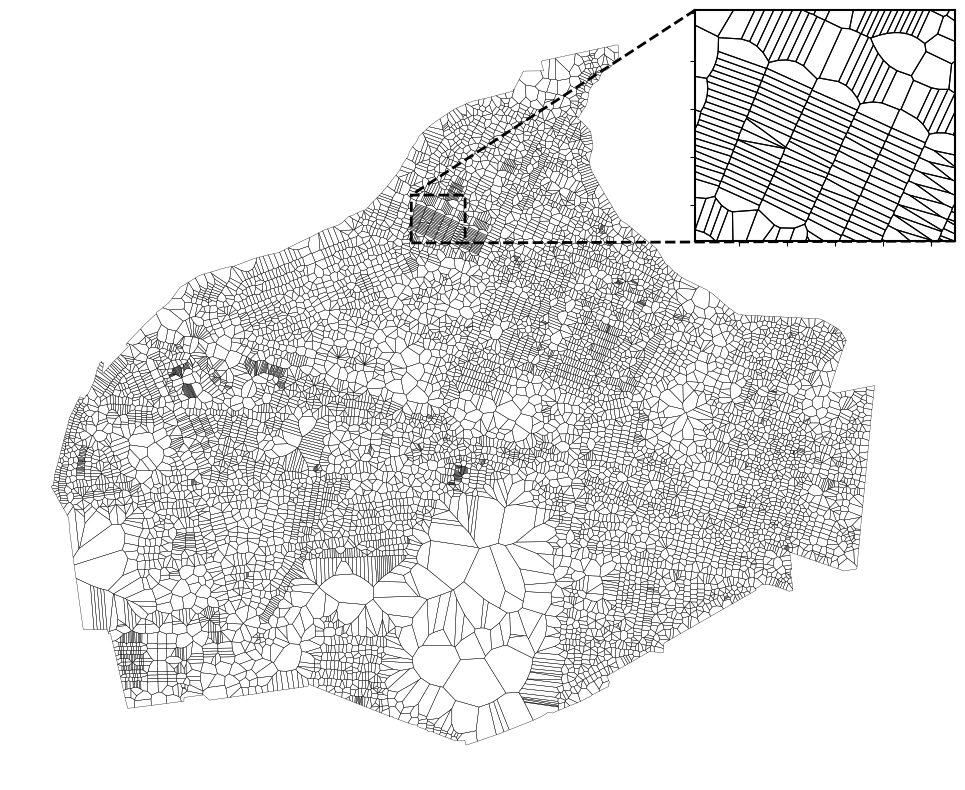

In [14]:
fig, ax = plt.subplots(figsize = (12, 8))

gdf = gpd.read_parquet('data/dk_adresser_voronoi.pq')
gdf_kom = gdf[gdf['kommunekode']==147].reset_index(drop=True)
gdf_kom.plot(ax = ax, facecolor='none', edgecolor='k', linewidth=0.25)
ax.set_axis_off()

# Define zoom coordinates
zoom_xlim = [		721305, 		721575]
zoom_ylim = [	6177113, 	6177353]

# Create inset axes for the zoom
# [x_position, y_position, width, height] in axes coordinates (0-1)
axins = ax.inset_axes([0.75, 0.7, 0.3, 0.3])

# Filter data for the zoom area
gdf_zoom = gdf_kom.cx[zoom_xlim[0]:zoom_xlim[1], zoom_ylim[0]:zoom_ylim[1]]

# Plot the zoomed data
gdf_zoom.plot(ax=axins, facecolor='none', edgecolor='k', linewidth=0.8)

# Set the zoom limits
axins.set_xlim(zoom_xlim)
axins.set_ylim(zoom_ylim)

# Remove tick labels from inset
axins.set_xticklabels([])
axins.set_yticklabels([])

# Add a border around the inset
for spine in axins.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

# Draw lines connecting the main plot to the inset
ax.indicate_inset_zoom(axins, edgecolor="k", linewidth=2, linestyle='--', alpha=1)

plt.tight_layout()
plt.show()
fig.savefig('figs/voronoi_tess_fberg.pdf', bbox_inches = 'tight')